In [147]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor as pt
import pymc_experimental as pmx
import seaborn as sns
from packaging import version
# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe
import warnings
warnings.filterwarnings('ignore')

In [148]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 1234
sns.set_theme(context="notebook", style="white")

# Scenario 1 

# pymc skeleton model

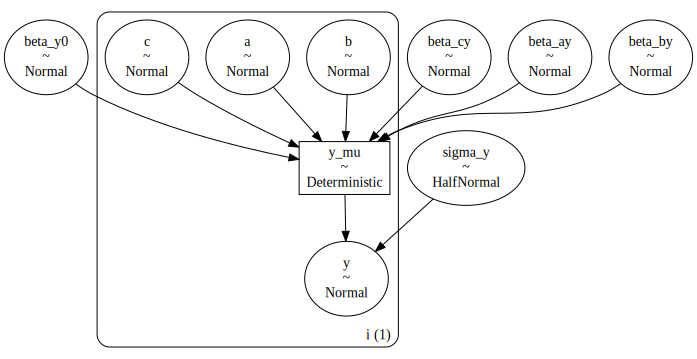

In [150]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_ay = pm.Normal("beta_ay")
    beta_by = pm.Normal("beta_by")
    beta_cy = pm.Normal("beta_cy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    a = pm.Normal("a", mu=0, sigma=1, dims="i")
    b = pm.Normal("b", mu=0, sigma=1, dims="i")
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_ay * a) + (beta_by * b) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")


pm.model_to_graphviz(model_generative)

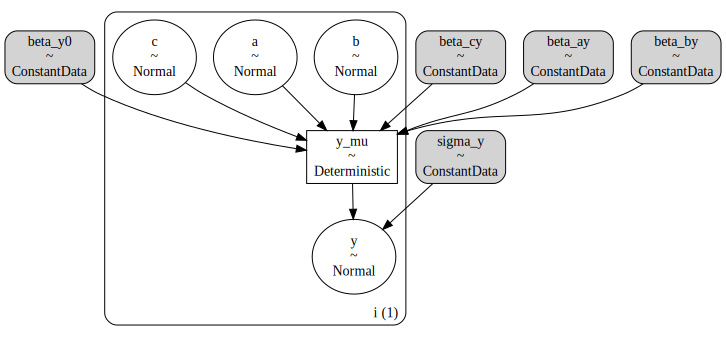

In [151]:
true_values = {
    "beta_ay": 1.5,
    "beta_by": 0.7,
    "beta_cy": 0.3,
    "sigma_y": 0.2,
    "beta_y0": 0.0
}

model_simulate = do(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

In [152]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)

observed = {
    "a": simulate.prior["a"].values.flatten(),
    "b": simulate.prior["b"].values.flatten(),
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten()
}

df = pd.DataFrame(observed)
df.to_csv('sample_data.csv', index=False)

Sampling: [a, b, c, y]


In [153]:
simulate

Inference data with groups:
	> prior
	> constant_data

In [154]:
print(df.shape)
df.head(5)

(100, 4)


,a,b,c,y
0,-0.792247,-1.148754,-0.261028,-2.104897
1,0.042728,-1.471836,2.062276,-0.070225
2,0.266376,0.145288,1.130260,1.039330
3,-0.183358,-0.072705,1.710885,-0.102585
4,1.742323,-0.986456,-0.686628,1.956717


In [155]:
df.corr()

,a,b,c,y
a,1.000000,-0.017964,-0.062937,0.867225
b,-0.017964,1.000000,-0.035735,0.428074
c,-0.062937,-0.035735,1.000000,0.114656
y,0.867225,0.428074,0.114656,1.000000


# Linear Regression

In [156]:
from sklearn.linear_model import LinearRegression
# Splitting data into predictors and target variable
X = df[['a', 'b', 'c']]
y = df['y']

# Building the linear regression model
model = LinearRegression()
model.fit(X, y)

# Getting the coefficients for each predictor
coefficients = model.coef_
coefficients


array([1.510979  , 0.69642109, 0.31906546])

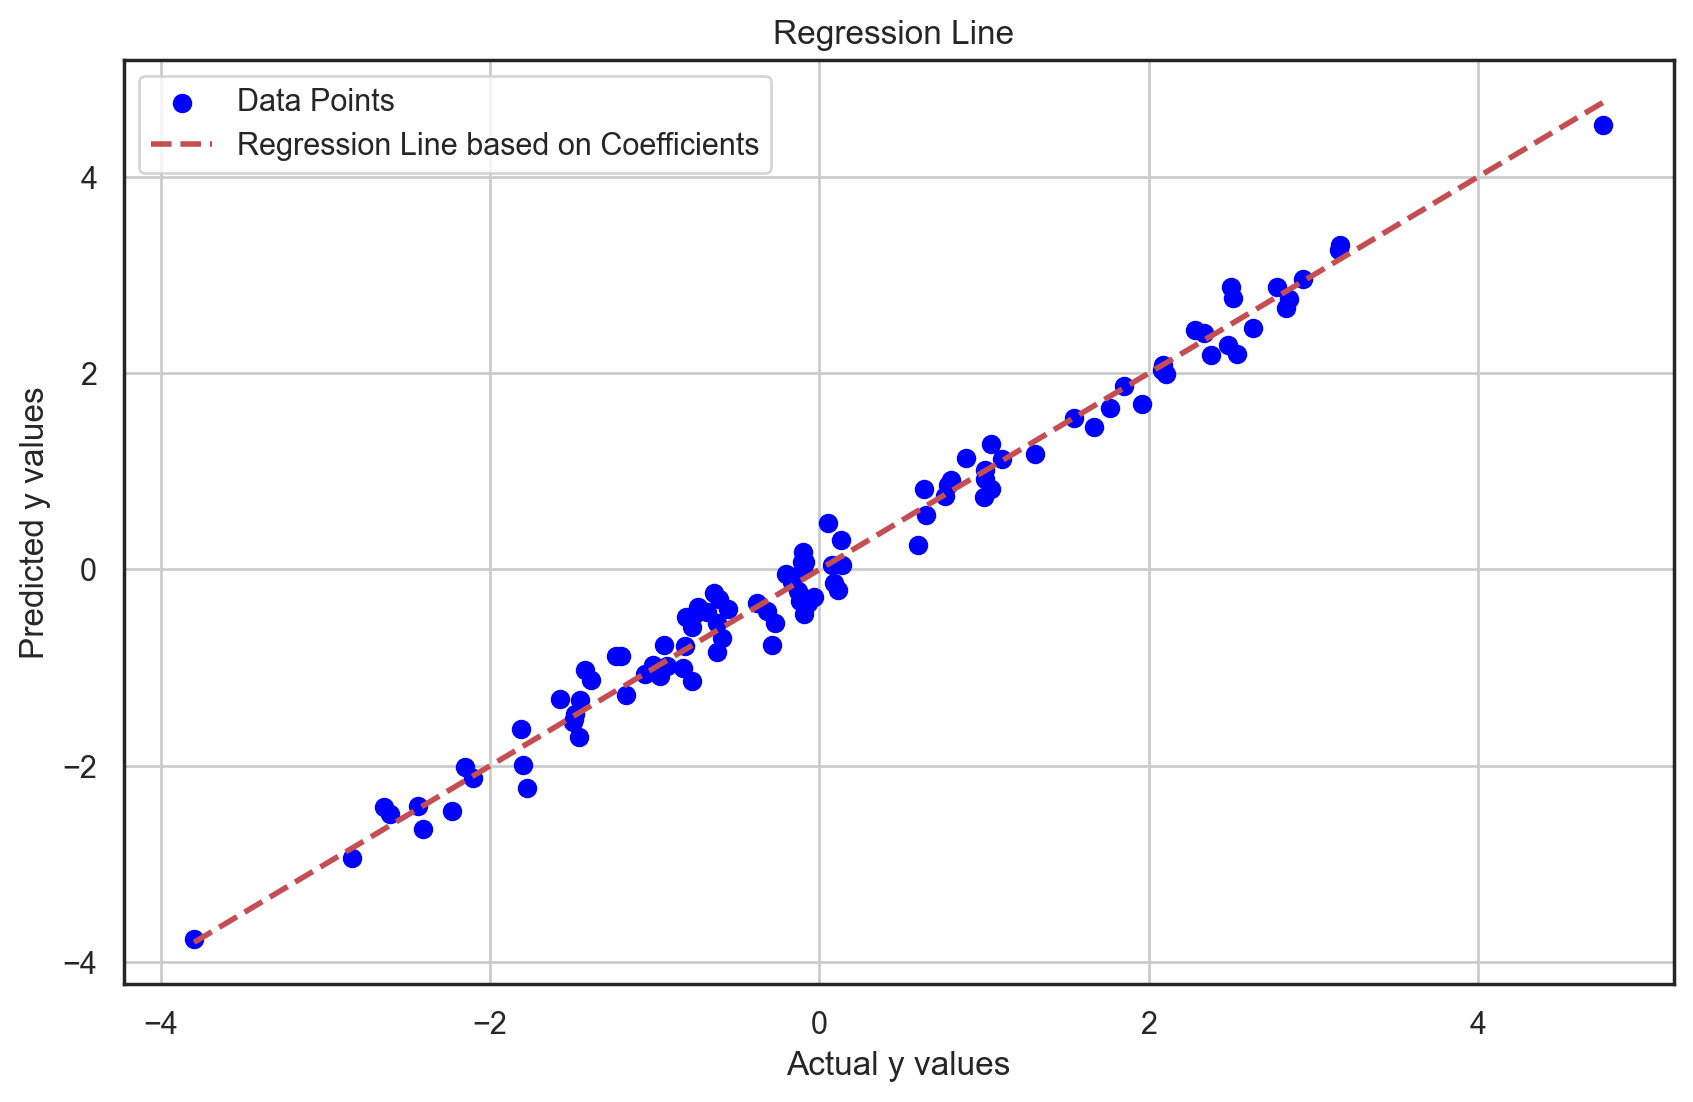

In [157]:
# Making predictions using the model
y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Data Points')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Regression Line based on Coefficients')
plt.title('Regression Line ')
plt.xlabel('Actual y values')
plt.ylabel('Predicted y values')
plt.legend()
plt.grid(True)
plt.show()


In [158]:
#df['y_pred_lr']=y_pred
#df

# Bayesian Regression

In [159]:
import pymc as pm

# Defining the Bayesian model
with pm.Model() as model:
    # Priors for the regression coefficients and intercept
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_a = pm.Normal('beta_a', mu=0, sigma=10)
    beta_b = pm.Normal('beta_b', mu=0, sigma=10)
    beta_c = pm.Normal('beta_c', mu=0, sigma=10)
    
    # Prior for the noise in the data
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Expected outcome
    mu = alpha + beta_a * X['a'] + beta_b * X['b'] + beta_c * X['c']
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sampling from the posterior
    trace = pm.sample(2000, tune=1000, cores=1)
    pm.sample_posterior_predictive(trace,extend_inferencedata=True)

# Summary of the posterior distributions of the parameters
pm.summary(trace).round(2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_a, beta_b, beta_c, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_obs]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.04,0.02,-0.08,0.00,0.0,0.0,4462.0,3318.0,1.0
beta_a,1.51,0.02,1.47,1.56,0.0,0.0,4526.0,3314.0,1.0
beta_b,0.70,0.02,0.66,0.74,0.0,0.0,6838.0,3595.0,1.0
beta_c,0.32,0.02,0.28,0.36,0.0,0.0,6564.0,3561.0,1.0
sigma,0.22,0.02,0.19,0.25,0.0,0.0,5015.0,2907.0,1.0


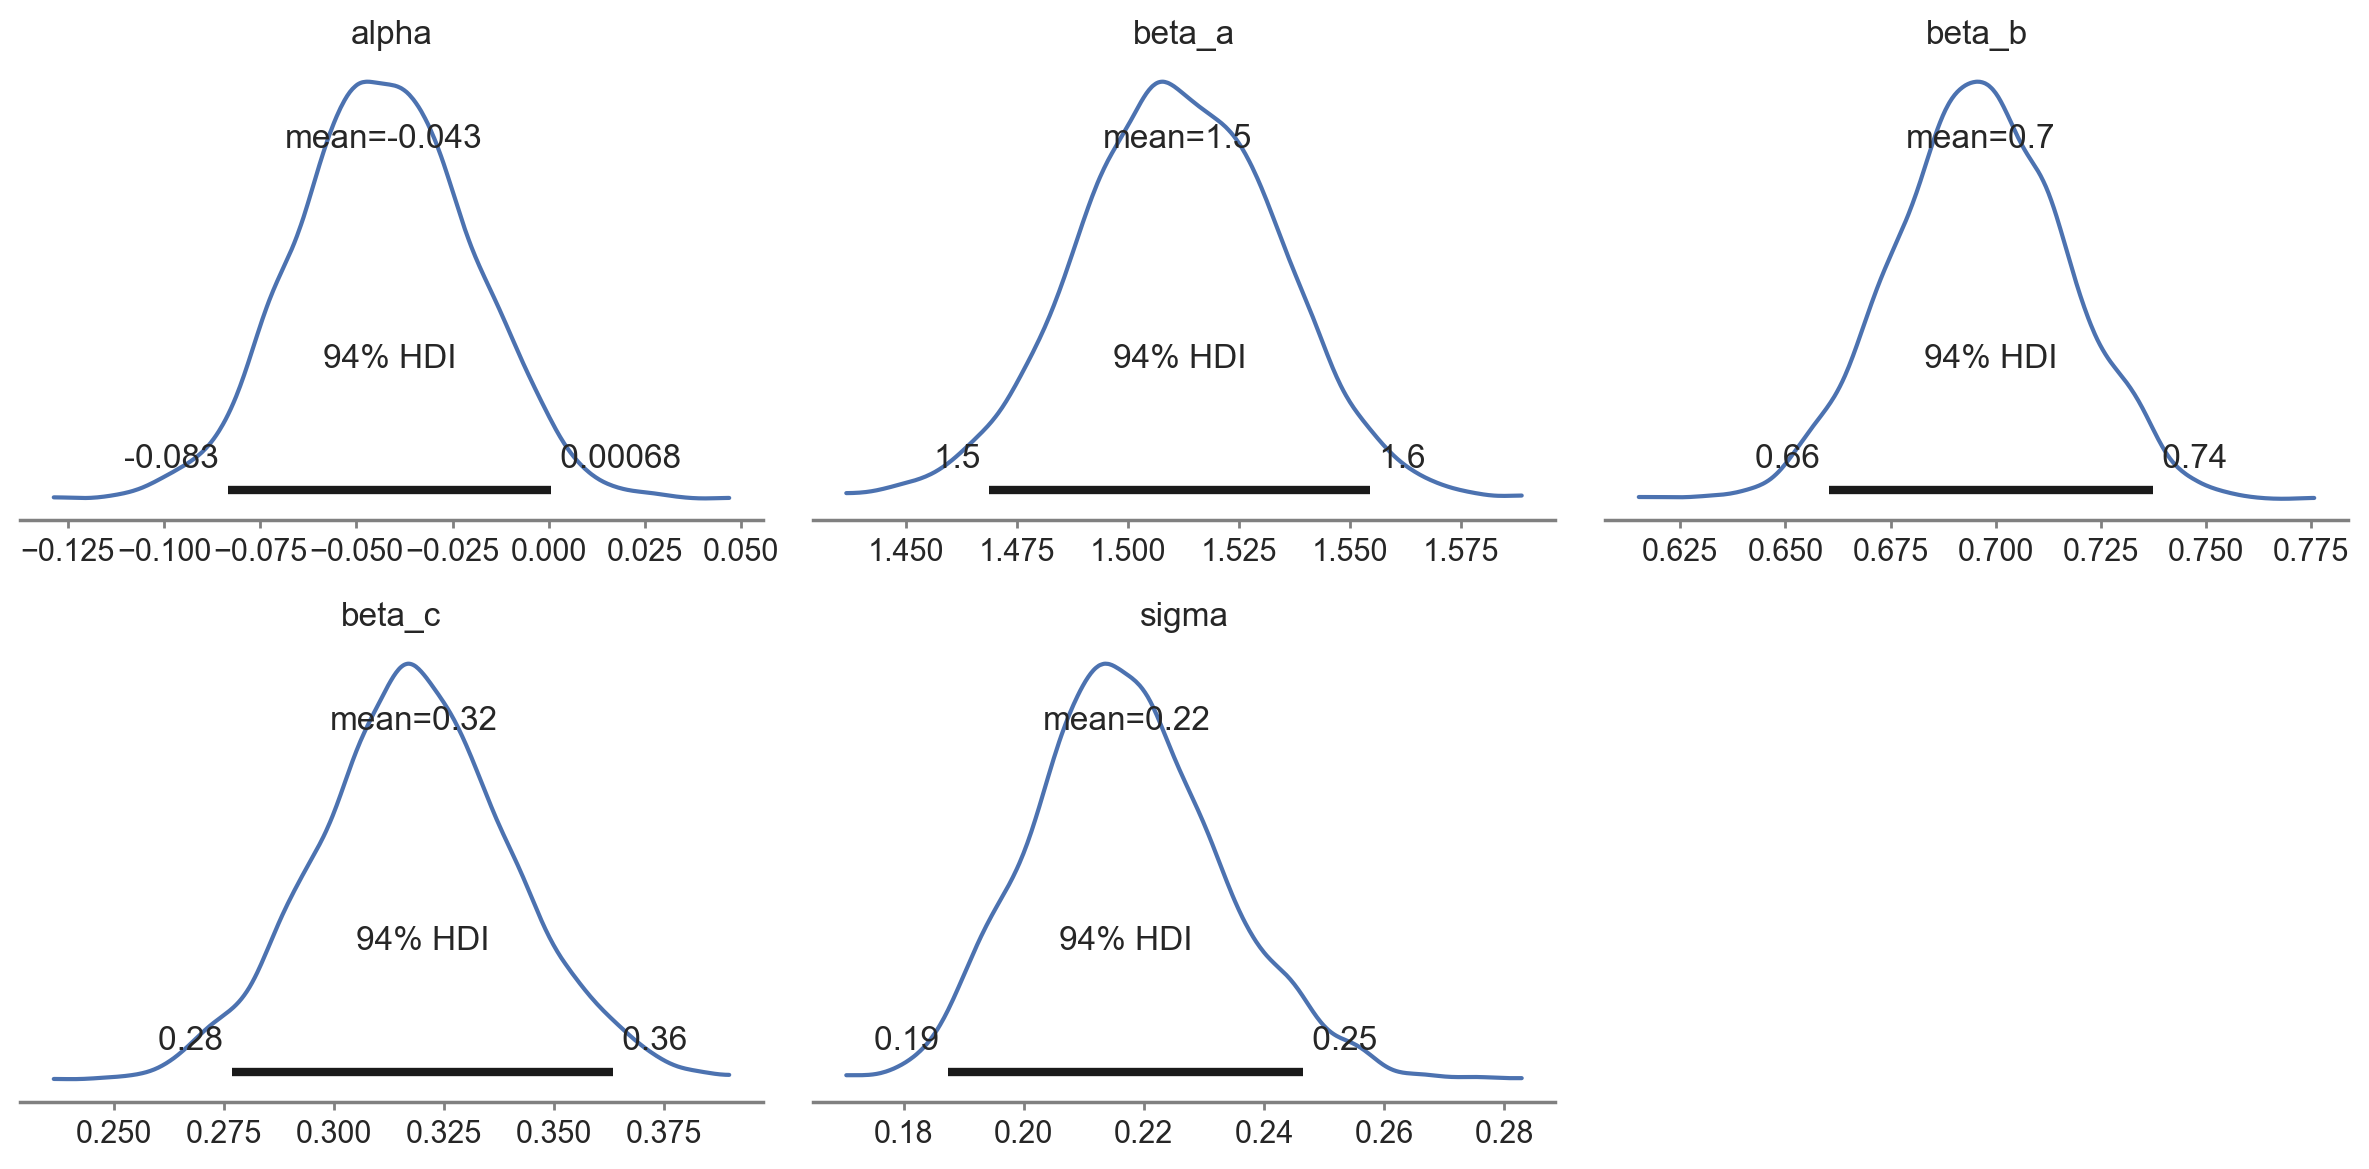

In [160]:
az.plot_posterior(trace,figsize=(12, 6),)
plt.tight_layout();

In [161]:
y_pred_bayesian=trace.posterior_predictive.stack(sample=("chain", "draw")).y_obs.values.T.mean(0)
#df['y_pred_bayes']=y_pred_bayesian
#df

In [162]:
y_pred_bayesian_std=trace.posterior_predictive.stack(sample=("chain", "draw")).y_obs.values.T.std(0)

In [163]:
#df['y_pred_bayes_std']=y_pred_bayesian_std
#df

In [164]:
#df.to_csv('sample_data_with_predictions.csv', index=False)

# Using observe-operator

In [165]:
model_inference_do = do(model_generative, {"a": df["a"], "b": df["b"], "c": df["c"], "y": df["y"]})

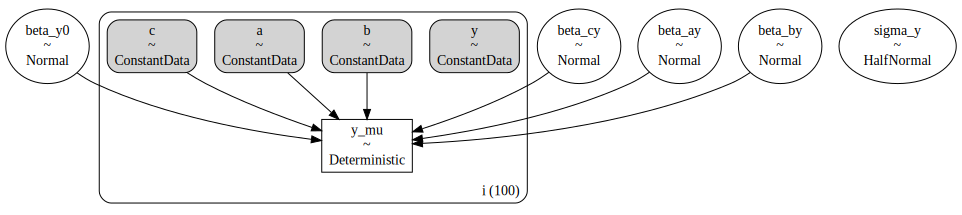

In [166]:
model_inference_do.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference_do)

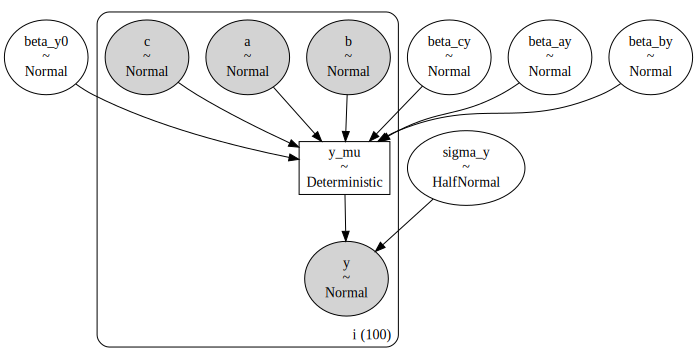

In [167]:
model_inference = observe(model_generative, {"a": df["a"], "b": df["b"], "c": df["c"], "y": df["y"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference)

In [168]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_ay, beta_by, beta_cy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


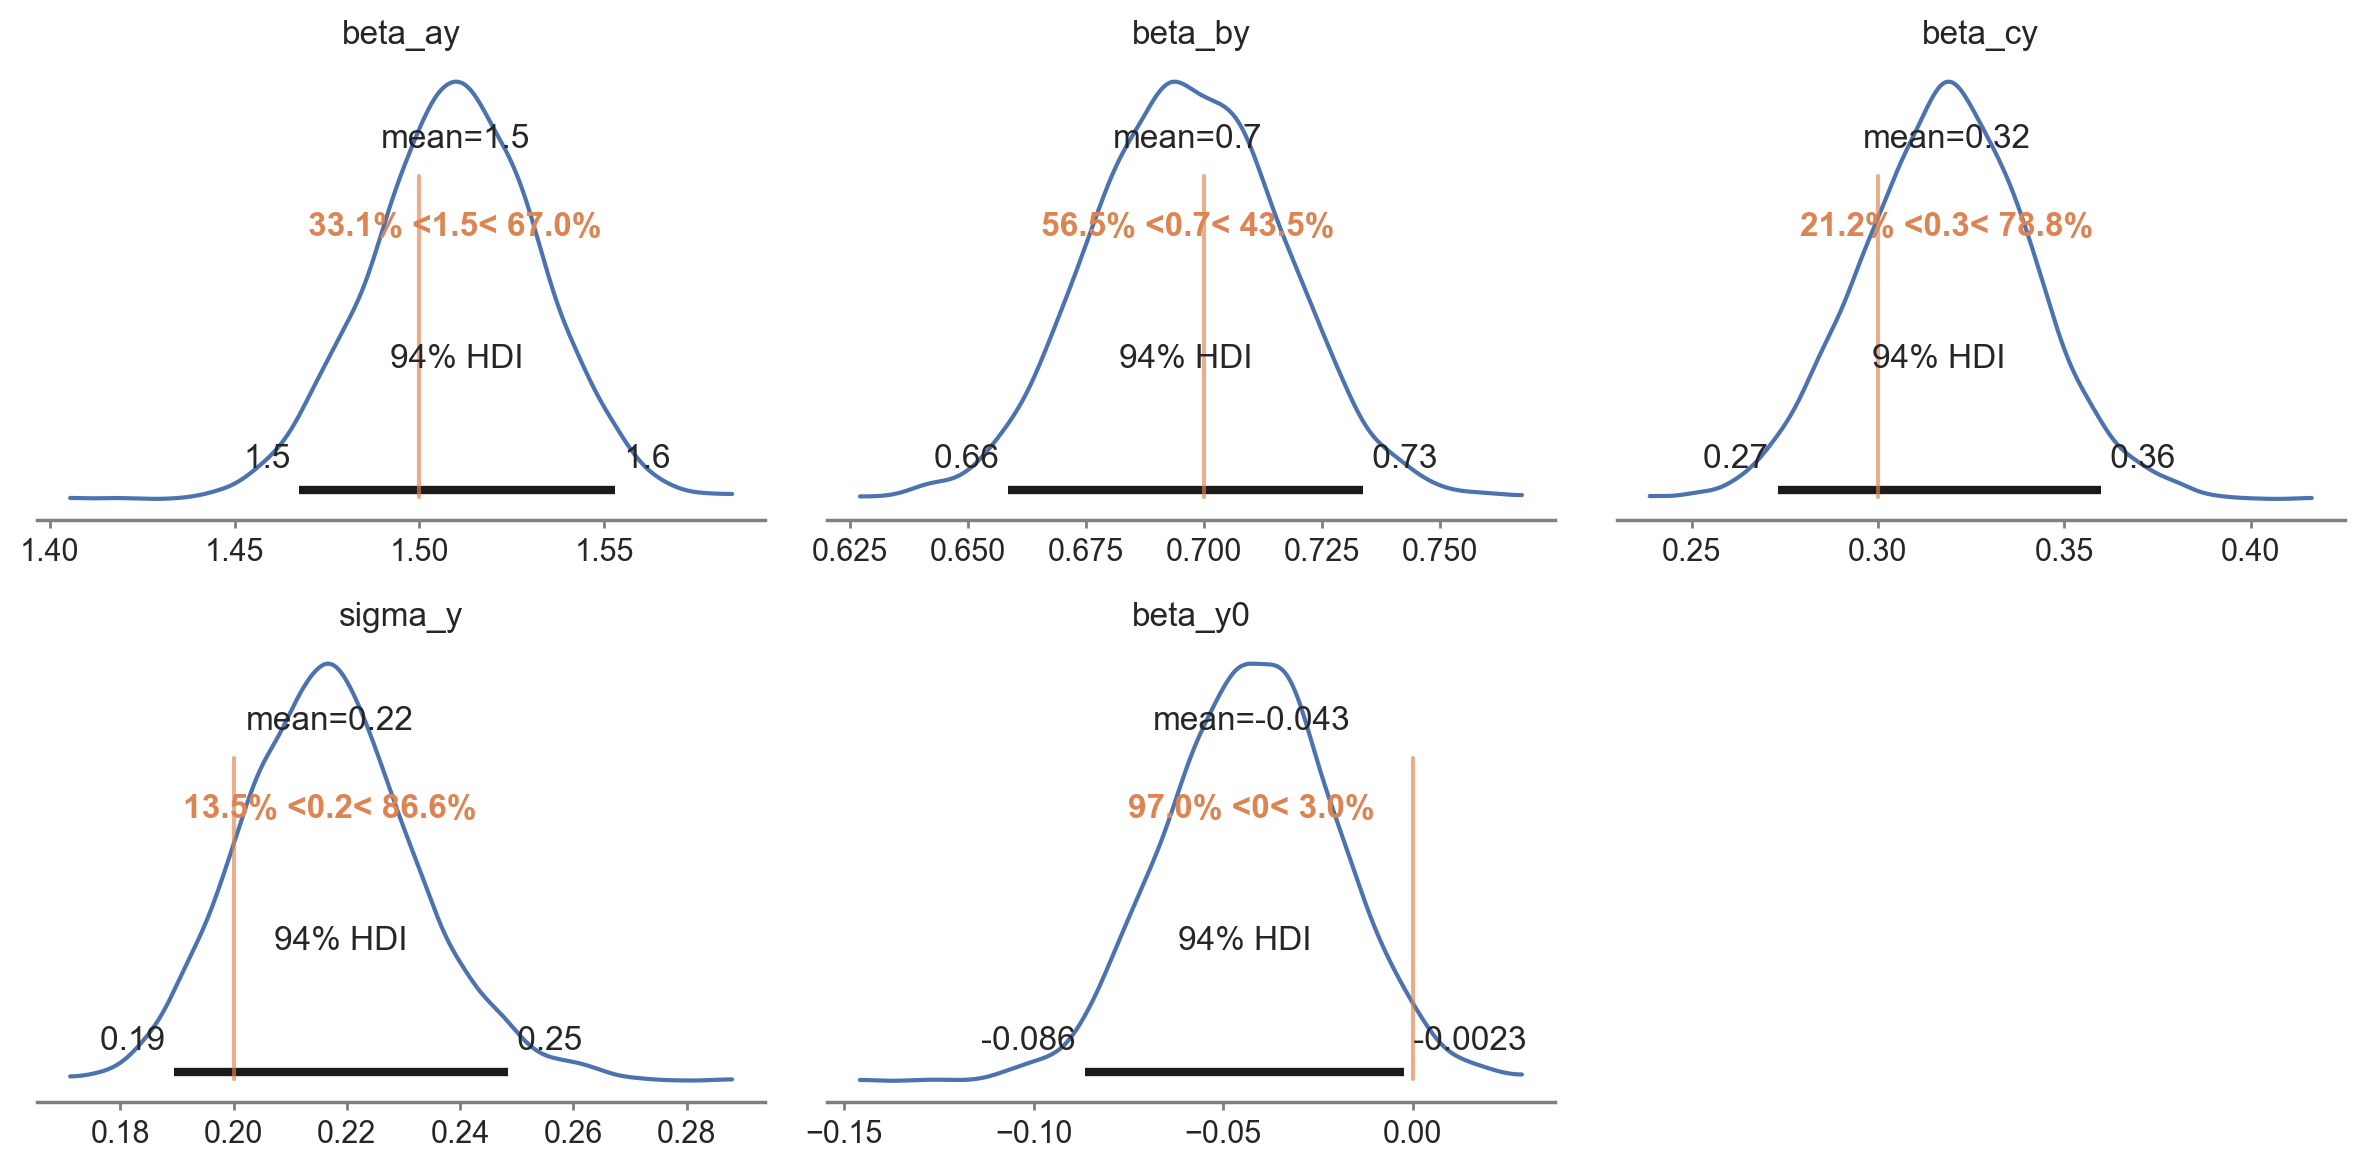

In [169]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

In [170]:
pm.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_y0,-0.04,0.02,-0.09,-0.00,0.0,0.0,5579.0,3331.0,1.0
beta_ay,1.51,0.02,1.47,1.55,0.0,0.0,5332.0,3035.0,1.0
beta_by,0.70,0.02,0.66,0.73,0.0,0.0,5271.0,3422.0,1.0
beta_cy,0.32,0.02,0.27,0.36,0.0,0.0,4239.0,3154.0,1.0
sigma_y,0.22,0.02,0.19,0.25,0.0,0.0,5063.0,3278.0,1.0
...,...,...,...,...,...,...,...,...,...
y_mu[95],2.44,0.04,2.36,2.52,0.0,0.0,4897.0,3459.0,1.0
y_mu[96],2.66,0.04,2.58,2.74,0.0,0.0,5812.0,3110.0,1.0
y_mu[97],0.56,0.05,0.45,0.65,0.0,0.0,6118.0,3244.0,1.0
y_mu[98],1.13,0.04,1.06,1.20,0.0,0.0,5623.0,3554.0,1.0


In [171]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [172]:
# Replace c with its observed values
# This is required because we only want to sample Y
model_counterfactual = do(model_inference, {"a": df["a"], "c": df["c"]})

In [173]:
# Scenario 1

In [174]:
# Generate models with Z=0 and Z=1
model_b0 = do(model_counterfactual, {"b": np.zeros(N, dtype="int32")}, prune_vars=True)
model_b1 = do(model_counterfactual, {"b": df["b"]}, prune_vars=True)

In [175]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


Sampling: []


In [176]:
df["b_scenario_1"]=0
df["y_scenario_1"]=idata_b0.predictions.y_mu.mean(("chain", "draw")).values.reshape(1, -1).flatten()
df.head(5)

,a,b,c,y,b_scenario_1,y_scenario_1
0,-0.792247,-1.148754,-0.261028,-2.104897,0,-1.321641
1,0.042728,-1.471836,2.062276,-0.070225,0,0.678544
2,0.266376,0.145288,1.130260,1.039330,0,0.719457
3,-0.183358,-0.072705,1.710885,-0.102585,0,0.225360
4,1.742323,-0.986456,-0.686628,1.956717,0,2.369212


In [177]:
# calculate estimated ATE
ATE_est = idata_b1.predictions - idata_b0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = -0.09


In [178]:
# Scenario 2

In [179]:
model_b0 = do(model_counterfactual, {"b": 5*df["b"]}, prune_vars=True)
model_b1 = do(model_counterfactual, {"b": df["b"]}, prune_vars=True)

In [180]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


Sampling: []


In [181]:
df["b_scenario_2"]=5*df["b"]
df["y_scenario_2"]=idata_b0.predictions.y_mu.mean(("chain", "draw")).values.reshape(1, -1).flatten()
df.head(5)

,a,b,c,y,b_scenario_1,y_scenario_1,b_scenario_2,y_scenario_2
0,-0.792247,-1.148754,-0.261028,-2.104897,0,-1.321641,-5.743772,-5.322203
1,0.042728,-1.471836,2.062276,-0.070225,0,0.678544,-7.359179,-4.447156
2,0.266376,0.145288,1.130260,1.039330,0,0.719457,0.726442,1.225427
3,-0.183358,-0.072705,1.710885,-0.102585,0,0.225360,-0.363524,-0.027836
4,1.742323,-0.986456,-0.686628,1.956717,0,2.369212,-4.932281,-1.066143


In [182]:
# calculate estimated ATE
ATE_est = idata_b1.predictions - idata_b0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.38


In [128]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_by", ref_val=0.7, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

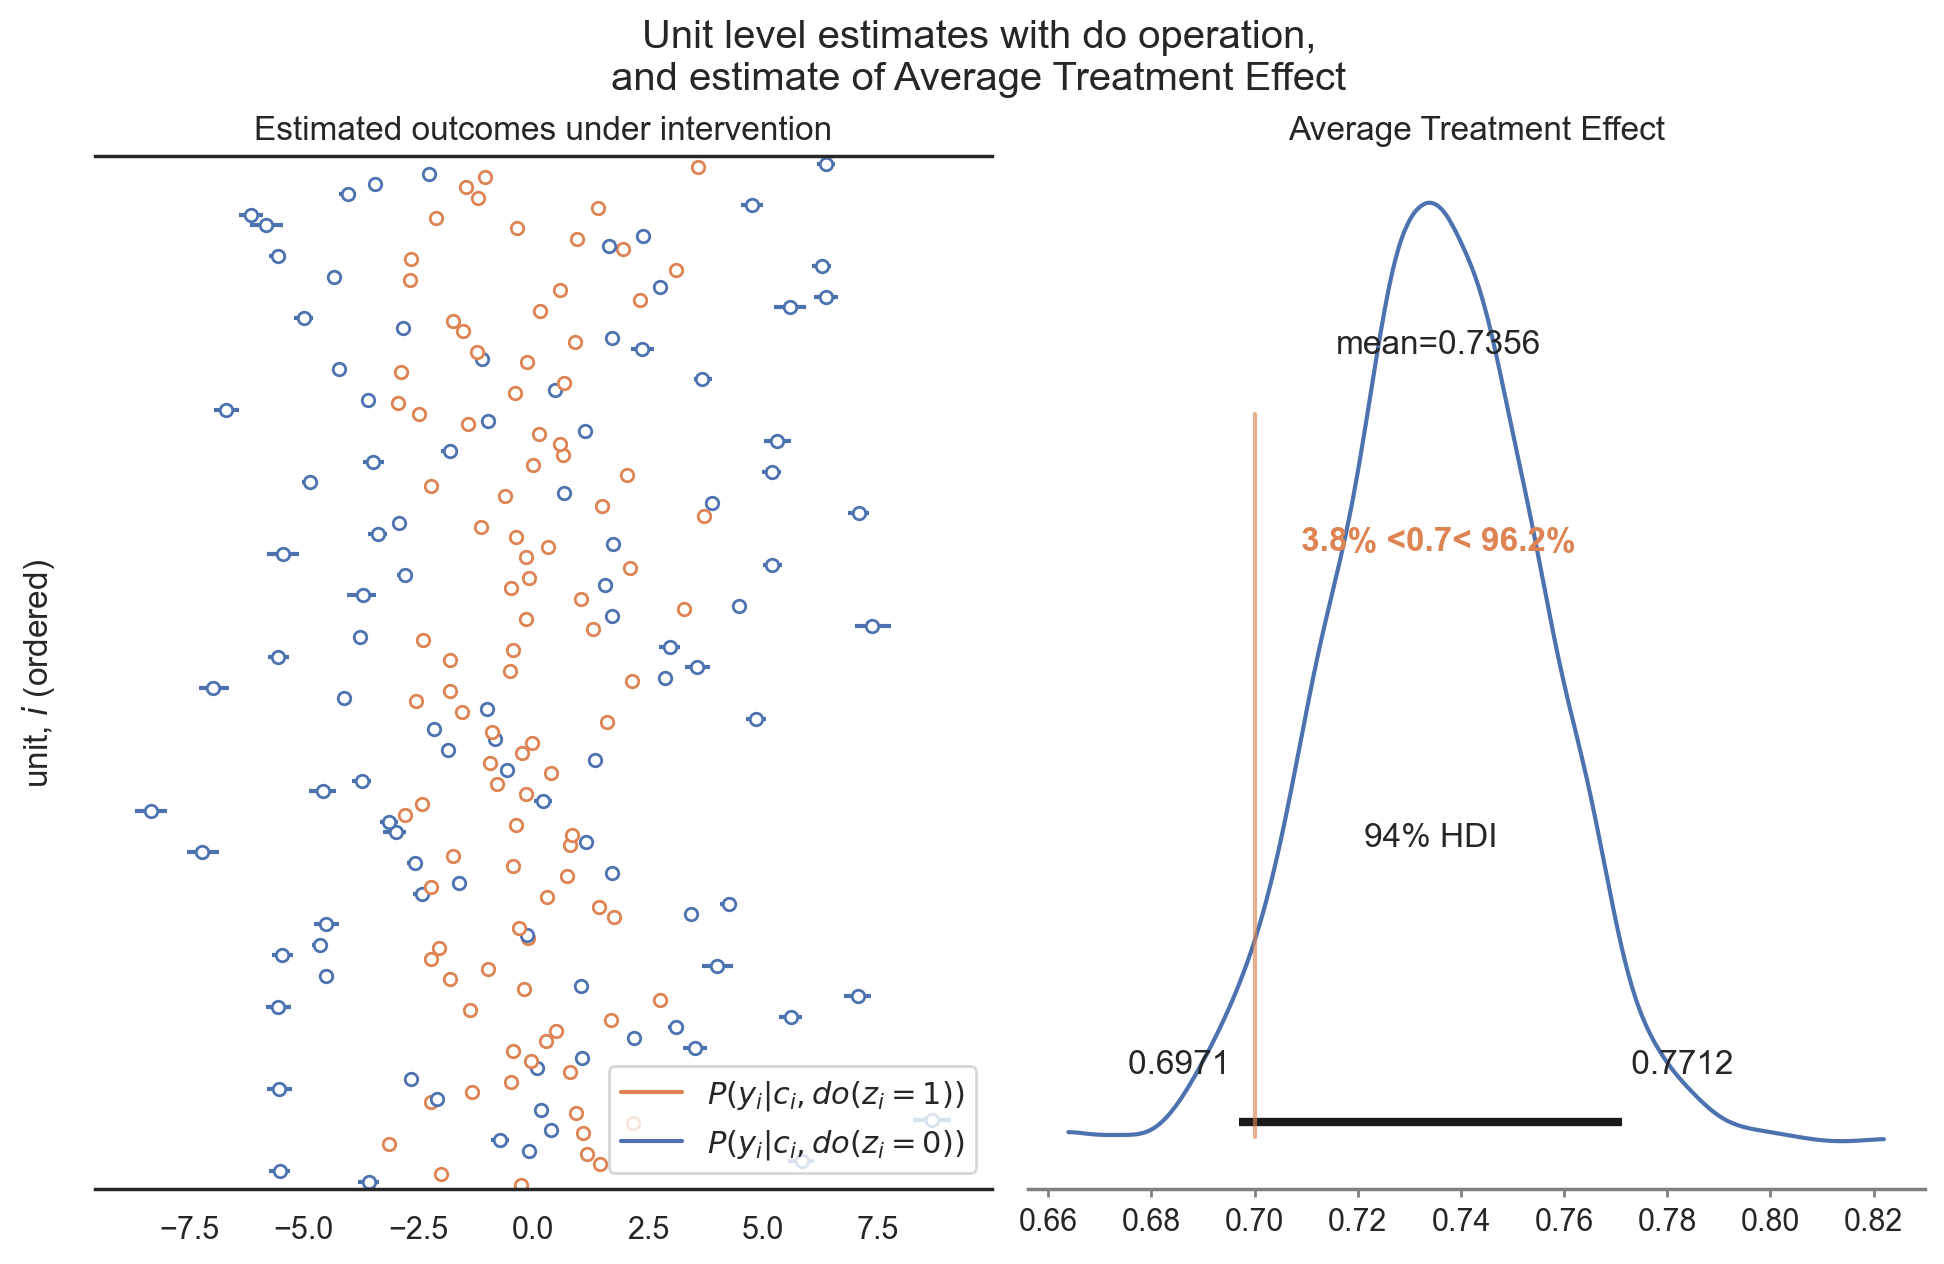

In [129]:
plot_causal_estimates(
    [idata_b0, idata_b1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

# Scenario 2

# Build model skeleton

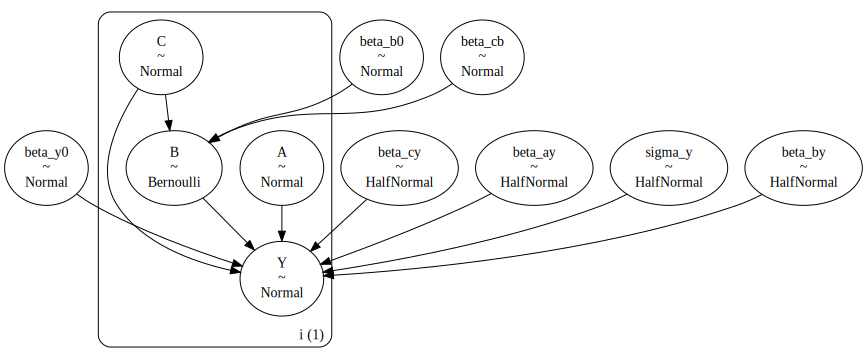

In [130]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    """
    # priors on Y <- C -> Z
    beta_b0 = pm.Normal("beta_b0")
    beta_cb = pm.Normal("beta_cb")
    beta_y0 = pm.Normal("beta_y0")
    beta_ay = pm.Normal("beta_ay")
    beta_by = pm.Normal("beta_by")
    beta_cy = pm.Normal("beta_cy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    a = pm.Normal("a", mu=0, sigma=1, dims="i")
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    #c = pm.Normal("c", mu=0, sigma=1, dims="i")
    b = pm.Bernoulli("b", p=pm.invlogit(beta_b0 + beta_cb * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_ay * a) + (beta_by * b) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")
"""

    # Priors
    # a ~ y
    beta_ay = pm.HalfNormal("beta_ay")
    # b ~ y
    beta_by = pm.HalfNormal("beta_by")
    # c ~ y
    beta_cy = pm.HalfNormal("beta_cy")
    
     # c ~ b
    beta_cb = pm.Normal("beta_cb")
    
    # priors on sigma
    beta_b0 = pm.Normal("beta_b0")
    beta_y0 = pm.Normal("beta_y0")
    
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    
    # model
    A = pm.Normal("A", mu=0, sigma=1, dims="i")
    C = pm.Normal("C", mu=0, sigma=1, dims="i")
    #B = pm.Normal("B", mu=beta_cb*C, sigma=beta_b0,  dims="i")
    B = pm.Bernoulli("B", p=pm.invlogit(beta_b0 + beta_cb * C), dims="i")
    
    # Expected outcome
    mu = beta_y0 + beta_ay * A + beta_by * B + beta_cy * C
    
    # Likelihood
    Y = pm.Normal("Y", mu=mu, sigma=sigma_y, dims="i")
    
    
pm.model_to_graphviz(model_generative)

# Generate parameters

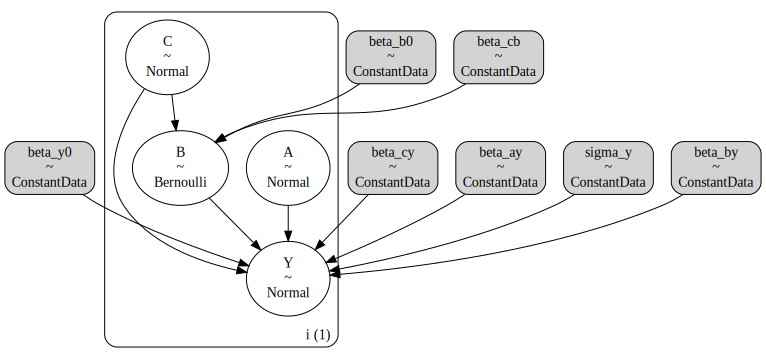

In [131]:
true_ATE = 0

true_values = {
    "beta_ay": 1.5,
    "beta_by": true_ATE,
    "beta_cy": 0.3,
    "beta_cb": 0.2,
    "sigma_y": 0.2,
    "beta_b0": 0.0,
    "beta_y0": 0.0
}

model_simulate = do(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

# Generate prior data

In [132]:
N = 1000

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)

observed = {
    "A": simulate.prior["A"].values.flatten(),
    "B": simulate.prior["B"].values.flatten(),
    "C": simulate.prior["C"].values.flatten(),
    "Y": simulate.prior["Y"].values.flatten()
}

df = pd.DataFrame(observed)
#df.to_csv('sample_data_2.csv', index=False)
df.head()

Sampling: [A, B, C, Y]


,A,B,C,Y
0,-0.380456,1,0.530614,-0.530399
1,-1.360479,0,-0.959837,-2.394763
2,0.697819,0,-0.841650,0.884738
3,0.112856,0,0.521793,-0.216952
4,2.324665,0,1.324589,4.231575


# Linear Regression

In [133]:
from sklearn.linear_model import LinearRegression
# Splitting data into predictors and target variable
X = df[['A', 'B', 'C']]
y = df['Y']

# Building the linear regression model
model = LinearRegression()
model.fit(X, y)

# Getting the coefficients for each predictor
coefficients = model.coef_
coefficients


array([1.50117364, 0.00496617, 0.29453587])

# Model using observe-operator

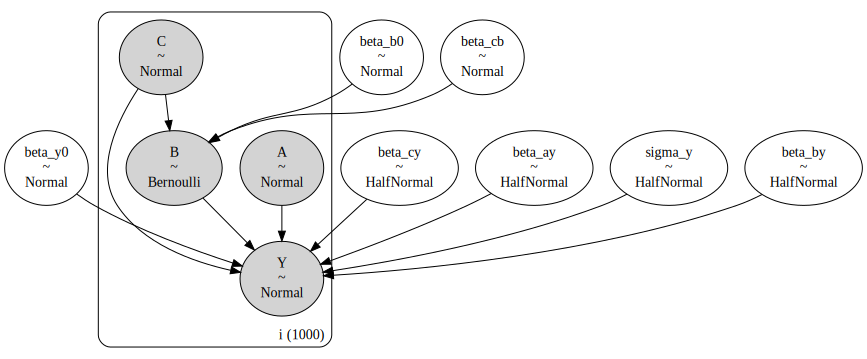

In [134]:
model_inference = observe(model_generative, {"A": df["A"], "B": df["B"], "C": df["C"], "Y": df["Y"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference)

In [135]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ay, beta_by, beta_cy, beta_cb, beta_b0, beta_y0, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [136]:
pm.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_cb,0.34,0.06,0.22,0.46,0.0,0.0,3277.0,2393.0,1.0
beta_b0,0.05,0.06,-0.07,0.17,0.0,0.0,3941.0,2710.0,1.0
beta_y0,-0.01,0.01,-0.02,0.01,0.0,0.0,2052.0,1863.0,1.0
beta_ay,1.50,0.01,1.49,1.51,0.0,0.0,2948.0,2173.0,1.0
beta_by,0.01,0.01,0.00,0.03,0.0,0.0,1757.0,1646.0,1.0
beta_cy,0.29,0.01,0.28,0.31,0.0,0.0,3022.0,2544.0,1.0
sigma_y,0.19,0.00,0.19,0.20,0.0,0.0,3439.0,2989.0,1.0


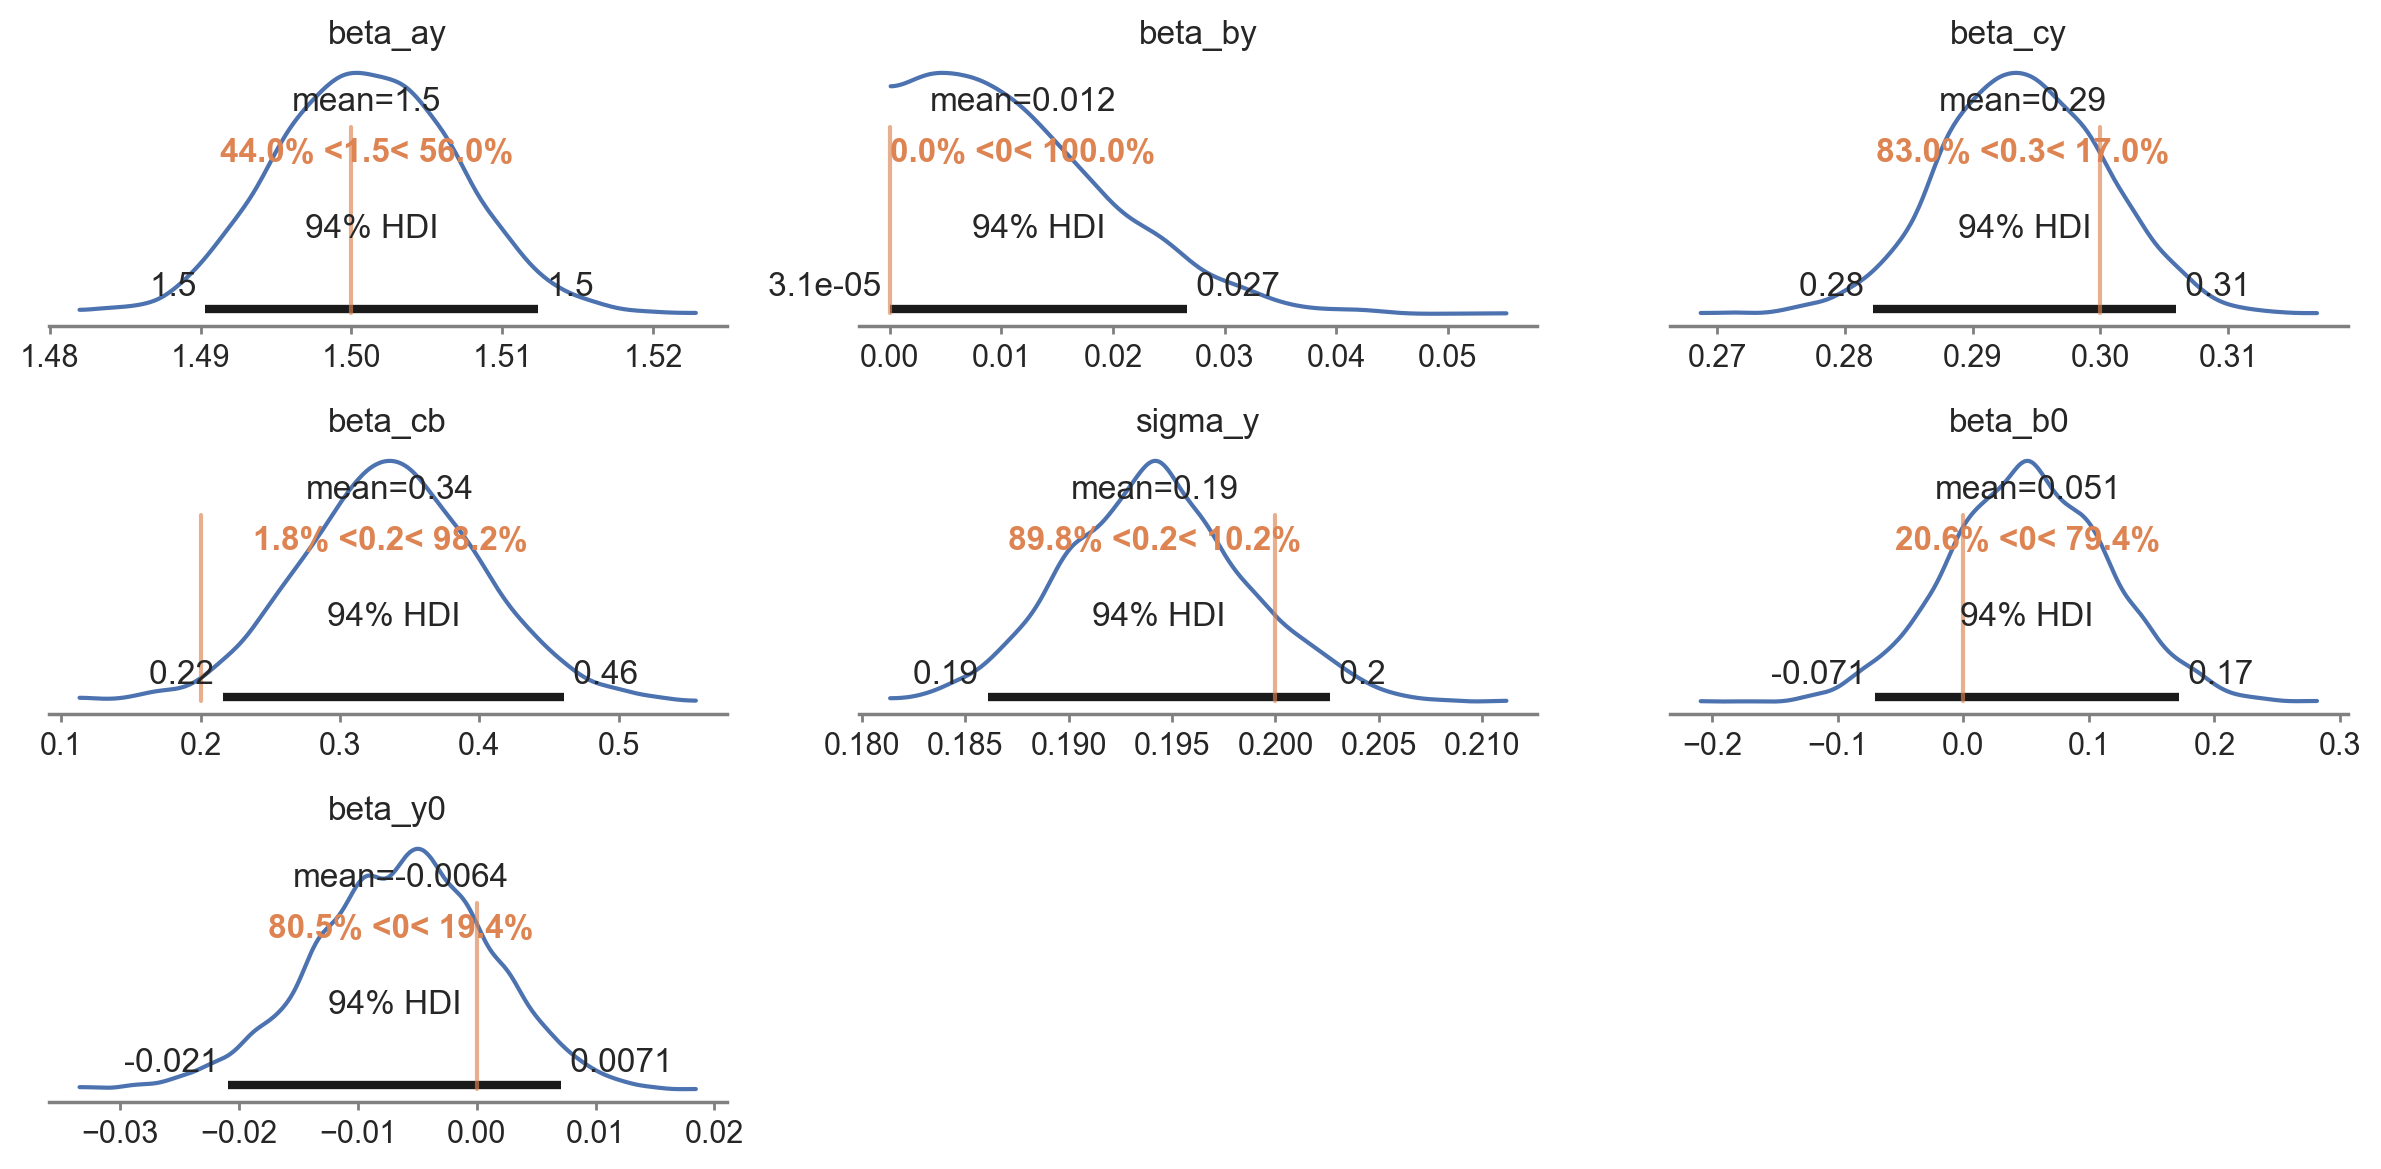

In [137]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

# pymc model

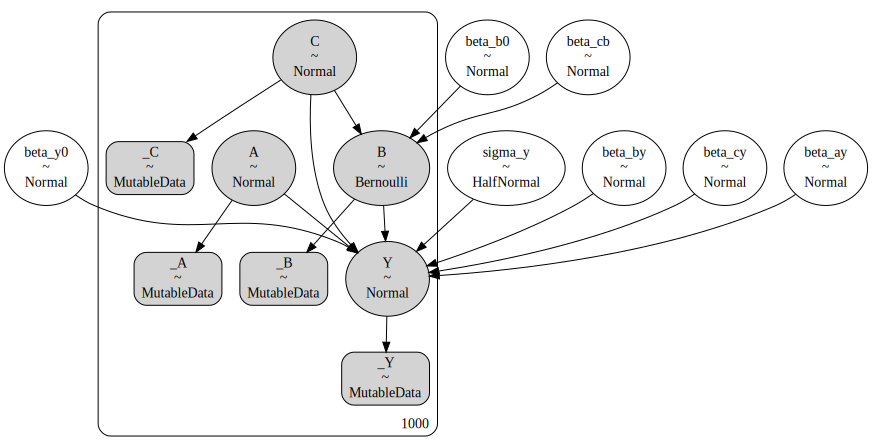

In [138]:
import pymc as pm

# Defining the Bayesian model
with pm.Model() as model:
    # data
    _A = pm.MutableData("_A", df["A"])
    _B = pm.MutableData("_B", df["B"])
    _C = pm.MutableData("_C", df["C"])
    _Y = pm.MutableData("_Y", df["Y"])
    
    # Priors
    # a ~ y
    beta_ay = pm.Normal("beta_ay")
    # b ~ y
    beta_by = pm.Normal("beta_by")
    # c ~ y
    beta_cy = pm.Normal("beta_cy")
    
     # c ~ b
    beta_cb = pm.Normal("beta_cb")
    
    # priors on sigma
    beta_b0 = pm.Normal("beta_b0")
    beta_y0 = pm.Normal("beta_y0")
    
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    
    # model
    A = pm.Normal("A", observed=_A)
    C = pm.Normal("C", observed=_C)
    #B = pm.Normal("B", mu=beta_cb*C, sigma=beta_b0, observed=_B)
    B = pm.Bernoulli("B", p=pm.invlogit(beta_b0 + beta_cb * C), observed=_B)
    
    # Expected outcome
    mu = beta_y0 + beta_ay * A + beta_by * B + beta_cy * C
    
    # Likelihood
    Y = pm.Normal("Y", mu=mu, sigma=sigma_y, observed=_Y)
    
pm.model_to_graphviz(model)

In [139]:
with model:
    # Sampling from the posterior
    trace = pm.sample(2000, tune=1000, cores=4)
    pm.sample_posterior_predictive(trace,extend_inferencedata=True)

# Summary of the posterior distributions of the parameters
pm.summary(trace).round(2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_ay, beta_by, beta_cy, beta_cb, beta_b0, beta_y0, sigma_y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
Sampling: [A, B, C, Y]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ay,1.50,0.01,1.49,1.51,0.0,0.0,11059.0,6380.0,1.0
beta_by,0.00,0.01,-0.02,0.03,0.0,0.0,8310.0,6586.0,1.0
beta_cy,0.30,0.01,0.28,0.31,0.0,0.0,10452.0,6174.0,1.0
beta_cb,0.34,0.06,0.21,0.46,0.0,0.0,10240.0,5794.0,1.0
beta_b0,0.05,0.06,-0.07,0.17,0.0,0.0,11146.0,5944.0,1.0
beta_y0,-0.00,0.01,-0.02,0.01,0.0,0.0,8638.0,6326.0,1.0
sigma_y,0.19,0.00,0.19,0.20,0.0,0.0,10987.0,5902.0,1.0


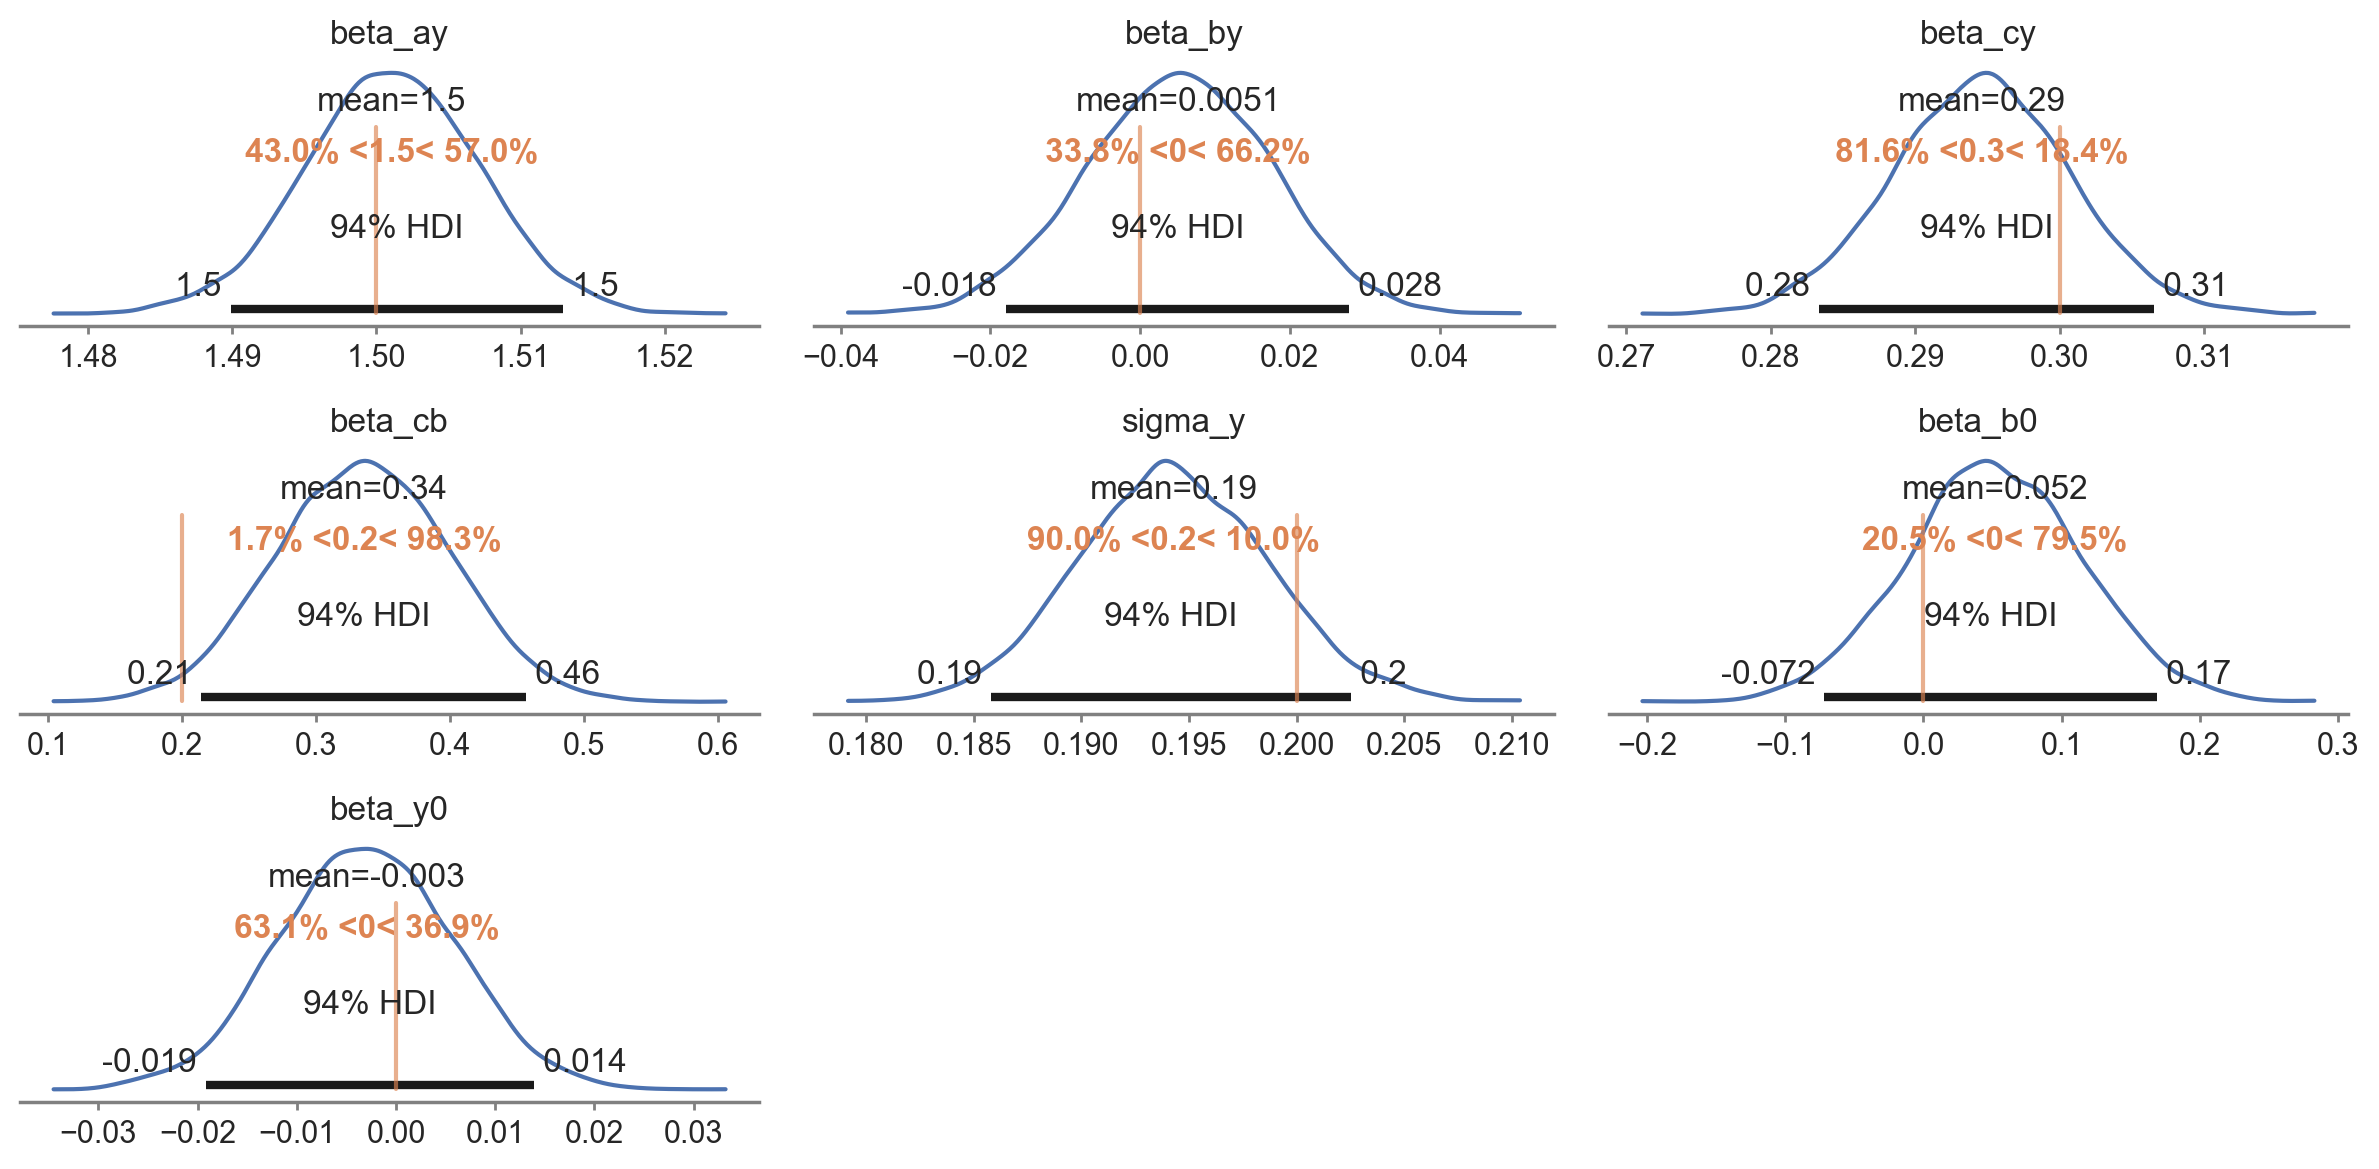

In [140]:
az.plot_posterior(
    trace,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

# do operator

In [141]:
# Replace c with its observed values
# This is required because we only want to sample Y
model_counterfactual = do(model_inference, {"A": df["A"], "C": df["C"]})

In [142]:
# Generate models with Z=0 and Z=1
model_b0 = do(model_counterfactual, {"B": np.zeros(N, dtype="int32")}, prune_vars=True)
model_b1 = do(model_counterfactual, {"B": np.ones(N, dtype="int32")}, prune_vars=True)

In [143]:
# Sample new sales data assuming Google Ads off: P(Y | c, do(z=0))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["Y"],
    random_seed=SEED,
)
# Sample new sales data assuming Google Ads on: P(Y | c, do(z=1))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["Y"],
    random_seed=SEED,
)

Sampling: [Y]


Sampling: [Y]


In [144]:
# calculate estimated ATE
ATE_est = idata_b1.predictions - idata_b0.predictions
print(f"Estimated ATE = {ATE_est.Y.mean().values:.2f}")

Estimated ATE = 0.01


In [145]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_by", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

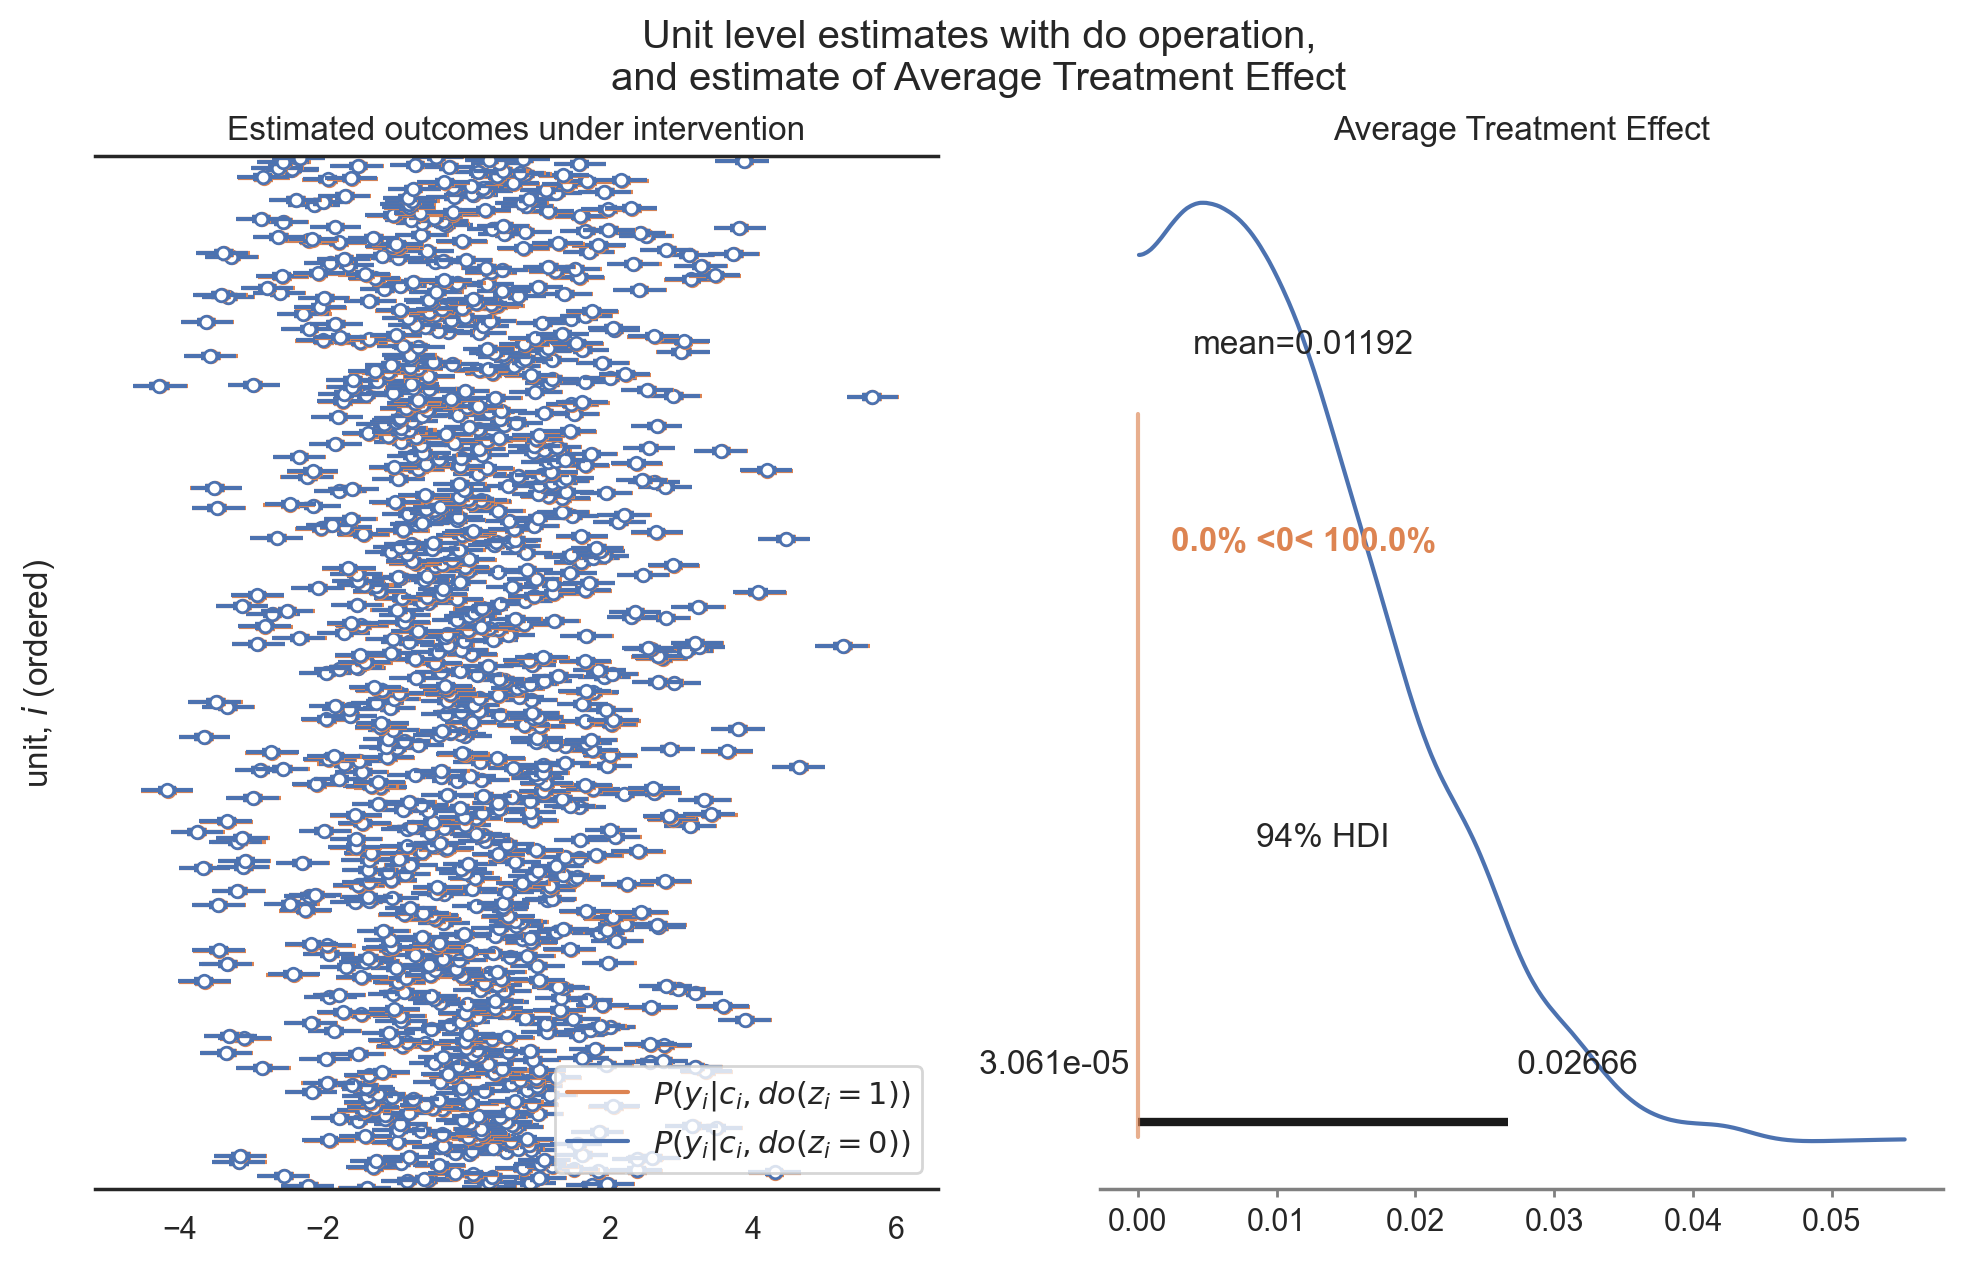

In [146]:
plot_causal_estimates(
    [idata_b0, idata_b1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)